# HW12

## Neural Networks for Images

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework

In [1]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

!wget -qO- https://github.com/DM-GY-9103-2024F-H/9103-utils/releases/latest/download/lfw.tar.gz | tar xz

In [2]:
import pandas as pd
import torch

from os import listdir, path
from sklearn.model_selection import train_test_split
from torch import nn, Tensor
from torch.utils.data import DataLoader

from data_utils import PCA, StandardScaler
from data_utils import classification_error, display_confusion_matrix
from data_utils import LFWUtils

from image_utils import make_image, open_image

from HW12_utils import HW12Utils, FaceDataset

## Neural Networks and PCA

We started seeing in class how Neural Networks can be _easy_ to build and explain in generic/abstract terms (a bunch of little operators that perform weighted sums of their inputs), but in reality can be really difficult and opaque to steer.

In theory, a couple of well placed neuron layers, with the right hyperparameters, learning rate, loss function, architecture and a good amount of data, can learn to extract information like polynomial features, clusters or PCA components. But... that's not always the case and sometimes it's not a bad idea to push/bias/encourage the network to go down a certain path.

One way to do this is to pre-process our inputs and do a bit of feature extraction ourselves.

Let's see if we can improve the face classification network from class by adding PCA information to our data.

### Start with the Data

As always, we start with the data, and this time put the pixel and label information straight into `Tensor` objects, but only so we can create a `DataLoader` for each of our datasets.

As a refresher... a `DataLoader` is a `PyTorch` objects that helps us _schedule_ how/when our data samples go through the model, by doing $2$ things, _batching_ and _shuffling_.

Batching is the process of selecting portions of our dataset, and shuffling is the process of switching the order of the samples before they go into batches.

There's usually no reason for shuffling the `test` dataset, but it's good to change up the order of our samples during training so the network doesn't learn just the order of the correct answers during training.

In [41]:
train, test = LFWUtils.train_test_split(0.5)

x_train = Tensor(train["pixels"])
y_train = Tensor(train["labels"]).long()

x_test = Tensor(test["pixels"])
y_test = Tensor(test["labels"]).long()

len(x_train), len(x_test)

(445, 438)

The `FaceDataset` class we saw in class is available in the `HW12_utils` file, so we can just use it here to wrap our `Tensor`s.

In [15]:
train_dataloader = DataLoader(FaceDataset(x_train, y_train), batch_size=128, shuffle=True)
test_dataloader = DataLoader(FaceDataset(x_test, y_test), batch_size=512)

### Let's train !

Oh no ! We don't have access to a GPU, so we can't use big neural networks.

Also, our dataset is kind of small, and only has at most $15$ samples from each class...

In these situations, it's not a bad idea to pre-process our data before sending it through training.

Let's create a single layer neural network, like the one from class, and train it with the `train_dataloader`.

In [16]:
# TODO: Create the model, optimizer and loss function objects
model = nn.Linear(x_train.shape[1], len(y_train.unique()))

learning_rate = 1e-6
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

### The Loop

Create a training loop like we saw in class.

The inner part of this loop should:
- Iterate through all batches of our `DataLoader`
- For each batch, predict classes
- Measure `loss`
- Get the optimizer to compute gradients
- Update parameters

This inner loop should be repeated as long as the loss keeps improving, and it doesn't look like the model is overfitting with the training data.

In order to check if the model is overfitting, we should sporadically run evaluation within the training loop in order to see if the model performs similarly with `train` and `test` data.

We can use the `HW12Utils.get_labels(model, dataloader)` to run our `model` on all the data in a given `dataloader` and return the true labels and predicted labels for all samples.

In [17]:
img, label = next(iter(train_dataloader))
out = model(img)

print("Input shape:", img.shape)
print("Output shape:", out.shape)

Input shape: torch.Size([128, 22100])
Output shape: torch.Size([128, 25])


In [18]:
# TODO: iterate epochs
for e in range(32):
  
  # TODO: iterate batches
  for imgs, labels in train_dataloader:

    # TODO: predict
    optim.zero_grad()
    labels_pred = model(imgs)

    # TODO: measure loss
    loss = loss_fn(labels_pred, labels)

    # TODO: compute gradient and step optimizer
    loss.backward()
    optim.step()

  # TODO: show progress
  if e % 4 == 3:
    print(f"Epoch: {e} loss: {loss.item():.4f}")

Epoch: 3 loss: 160.7488
Epoch: 7 loss: 42.2310
Epoch: 11 loss: 40.0271
Epoch: 15 loss: 15.4869
Epoch: 19 loss: 9.0912
Epoch: 23 loss: 3.4635
Epoch: 27 loss: 0.5419
Epoch: 31 loss: 1.5033


### Evaluate

This should be similar to the last error values seen during training, but sometimes it changes a bit...

Not a bad idea to check the accuracy of the model using the `classification_error()` function, and look at some confusion matrices.

In [20]:
def get_labels(model, dataloader):
  model.eval()
  with torch.no_grad():
    data_labels = []
    pred_labels = []
    for imgs, labels in dataloader:
      labels_pred = model(imgs).argmax(dim=1)
      data_labels += [l.item() for l in labels]
      pred_labels += [l.item() for l in labels_pred]
    return data_labels, pred_labels

train error: 0.0517
test error 0.5320


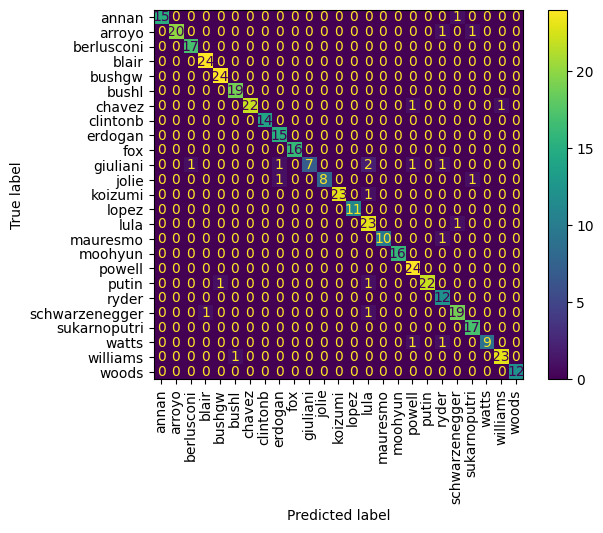

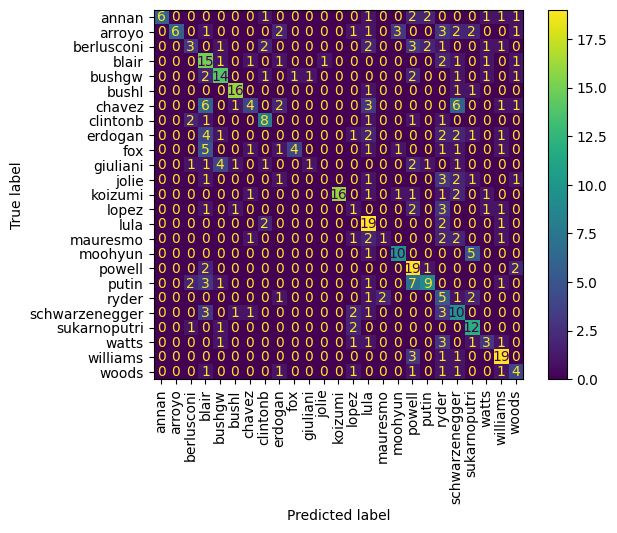

In [22]:
# TODO: classification error for train and test data
train_labels, train_predictions = get_labels(model, train_dataloader)
test_labels, test_predictions = get_labels(model, test_dataloader)

print("train error:", f"{classification_error(train_labels, train_predictions):.4f}")
print("test error", f"{classification_error(test_labels, test_predictions):.4f}")

# TODO: confusion matrices for train and test data
display_confusion_matrix(train_labels, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(test_labels, test_predictions, display_labels=LFWUtils.LABELS)

### Add PCA

We're going to repeat the training, but this time our data is gonna be scaled and PCA'd before going into the neural network.

Although it would be a bit unconventional for other types of models to scale `PCA` results, since our networks work better with scaled, well-proportioned data, here we'll have to scale the `PCA` results as well.

So, the data preparation flow should be:
- Scale data for `PCA`
- Perform `PCA`
- Scale data for Network

We need two `StandardScaler()` objects and one `PCA()` object.

The `train` data goes through the `fit_transform()` function of these objects, while the `test` data only goes through `transform()`.

For the `PCA`, an explained variance of about $90\%$ should be good, and, after the whole flow is set up, is something that can be experimented with.

In [30]:
train_df = pd.DataFrame(train)
expanded_pixels = train_df["pixels"].apply(pd.Series)
train_df = pd.concat([train_df.drop(columns=["pixels"]), expanded_pixels], axis=1)

test_df = pd.DataFrame(test)
expanded_pixels = test_df["pixels"].apply(pd.Series)
test_df = pd.concat([test_df.drop(columns=["pixels"]), expanded_pixels], axis=1)

In [42]:
test_df.head()

,labels,files,0,1,2,3,4,5,6,7,...,22090,22091,22092,22093,22094,22095,22096,22097,22098,22099
0,0,annan-028.jpg,97,97,98,99,101,103,104,106,...,70,71,71,73,76,79,83,85,88,89
1,0,annan-013.jpg,63,62,62,62,62,61,59,58,...,52,53,54,55,56,57,56,56,58,59
2,0,annan-026.jpg,82,83,85,86,87,88,88,88,...,49,48,45,44,45,48,51,53,58,63
3,0,annan-016.jpg,201,202,203,205,207,208,210,210,...,78,100,117,133,153,162,162,167,169,169
4,0,annan-006.jpg,64,64,64,63,63,63,62,62,...,73,73,73,71,69,68,69,71,77,78


In [59]:
# TODO: Scale
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(train_df.drop(columns=["labels","files"]))
x_test_scaled = scaler.transform(test_df.drop(columns=["labels","files"]))

# TODO: PCA
face_pca = PCA(n_components=90)
pca_train = face_pca.fit_transform(x_train_scaled)
pca_test = face_pca.transform(x_test_scaled)
print(face_pca.explained_variance())

# TODO: Scale
scaler2 = StandardScaler()
pca_train_scaled = scaler2.fit_transform(pca_train)
pca_train_scaled["label"] = train_df["labels"]

pca_test_scaled = scaler2.transform(pca_test)
pca_test_scaled["label"] = test_df["labels"]

0.9050115604019577


In [61]:
# TODO: Tensors
x_train_pca = Tensor(pca_train_scaled.drop(columns=['label']).values)
y_train_pca = Tensor(pca_train_scaled["label"].values).long()

x_test_pca = Tensor(pca_test_scaled.drop(columns=['label']).values)
y_test_pca = Tensor(pca_test_scaled["label"].values).long()

### Repeat

Re-create `DataLoaders`, model, optimizer, loss function, then re-run the training loop and evaluate.

Epoch: 3 loss: 3.3763
Epoch: 7 loss: 3.3644
Epoch: 11 loss: 3.4292
Epoch: 15 loss: 3.3399
Epoch: 19 loss: 3.4314
Epoch: 23 loss: 3.3345
Epoch: 27 loss: 3.4451
Epoch: 31 loss: 3.4238
Epoch: 35 loss: 3.4322
Epoch: 39 loss: 3.4997
Epoch: 43 loss: 3.4583
Epoch: 47 loss: 3.2557
Epoch: 51 loss: 3.4970
Epoch: 55 loss: 3.3195
Epoch: 59 loss: 3.4530
Epoch: 63 loss: 3.4600
Epoch: 67 loss: 3.5952
Epoch: 71 loss: 3.5042
Epoch: 75 loss: 3.4820
Epoch: 79 loss: 3.3301
Epoch: 83 loss: 3.3538
Epoch: 87 loss: 3.4712
Epoch: 91 loss: 3.4993
Epoch: 95 loss: 3.3857
Epoch: 99 loss: 3.3417
train error: 0.9573
test error 0.9680


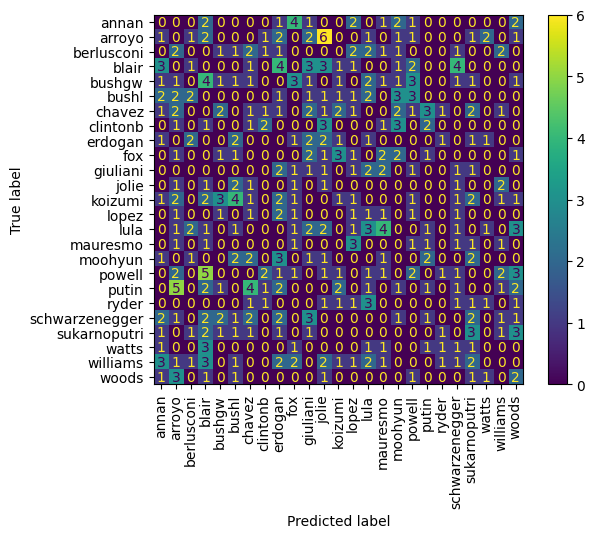

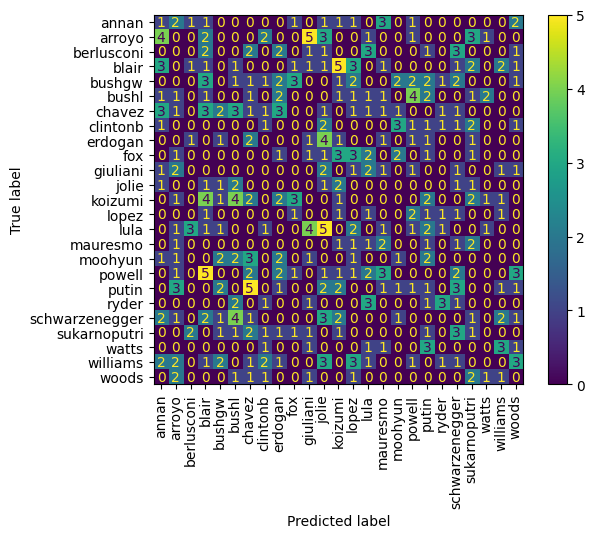

In [62]:
# TODO: DataLoaders
train_dataloader_pca = DataLoader(FaceDataset(x_train_pca, y_train_pca), batch_size=128, shuffle=True)
test_dataloader_pca = DataLoader(FaceDataset(x_test_pca, y_test_pca), batch_size=512)

# TODO: Model, Optimizer and Loss Function
model_pca = nn.Linear(x_train_pca.shape[1], len(y_train_pca.unique()))
learning_rate_pca = 1e-6
optim_pca = torch.optim.SGD(model_pca.parameters(), lr=learning_rate_pca, momentum=0.9)
loss_fn_pca = nn.CrossEntropyLoss()

# TODO: Training loop
img, label = next(iter(train_dataloader_pca))

for e in range(100):
  for imgs, labels in train_dataloader_pca:
    optim_pca.zero_grad()
    labels_pred_pca = model_pca(imgs)
    loss_pca = loss_fn_pca(labels_pred_pca, labels)
    loss_pca.backward()
    optim_pca.step()
  
  if e % 4 == 3:
    print(f"Epoch: {e} loss: {loss_pca.item():.4f}")

# TODO: Evaluation
train_labels_pca, train_predictions_pca = get_labels(model_pca, train_dataloader_pca)
test_labels_pca, test_predictions_pca = get_labels(model_pca, test_dataloader_pca)

print("train error:", f"{classification_error(train_labels_pca, train_predictions_pca):.4f}")
print("test error", f"{classification_error(test_labels_pca, test_predictions_pca):.4f}")

# TODO: confusion matrices for train and test data
display_confusion_matrix(train_labels_pca, train_predictions_pca, display_labels=LFWUtils.LABELS)
display_confusion_matrix(test_labels_pca, test_predictions_pca, display_labels=LFWUtils.LABELS)

### Interpretation

<span style="color:hotpink;">
So... What happened ?<br>How does the <code>PCA</code> version of the NN compare to the regular version ?<br>How much of the improvement is from <code>PCA</code> and how much from scaling ?
</span>

I probably did something wrong with the scaling and PCA because the results of NN with PCA is pretty terrible. Actually confused about the second scaler after PCA. If we already scaled the input to PCA, won't the output be already scaled?